### This notebook consists of the code to analyse the Movie Data for Box office Prediction. The goal of the analysis is to come up with a regression model which will predict the ptential box office revenue for a movie, given its features - Title,Tagline, Overview, Keywords, Genres etc. This prediction will aid in planning the budget for the movie.

#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy import stats
import sklearn
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,f1_score,precision_recall_curve
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.externals import joblib
import xgboost as xgb
import lightgbm
from lightgbm import LGBMRegressor,LGBMClassifier
from sklearn.model_selection import KFold,train_test_split

### Load the dataset and initial Analysis

In [2]:
df=pd.read_csv('Movie_Revenue_Predictions.csv')
print(df.shape)

(4803, 16)


In [3]:
for i in df.columns:
    print(i,' - ', df[i].dtype)

title  -  object
tagline  -  object
revenue  -  int64
budget  -  int64
genres  -  object
homepage  -  object
id  -  int64
keywords  -  object
original_language  -  object
overview  -  object
production_companies  -  object
production_countries  -  object
release_date  -  object
runtime  -  float64
spoken_languages  -  object
status  -  object


#### Note here the variable to be predicted is the 'revenue' column. Lets take a look at sample records


In [4]:
for j in list(df[df['revenue']==0].index)[:10]:
    print('The listing is below for movie id - ' + str(j))
    for i in df.columns:
        print(i , ' - ', df[df['revenue']==0][i].loc[j])
    print('\n')

The listing is below for movie id - 83
title  -  The Lovers
tagline  -  Love is longer than life.
revenue  -  0
budget  -  27000000
genres  -  [{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 878, "name": "Science Fiction"}, {"id": 10749, "name": "Romance"}]
homepage  -  nan
id  -  79698
keywords  -  []
original_language  -  en
overview  -  The Lovers is an epic romance time travel adventure film. Helmed by Roland Joffé from a story by Ajey Jhankar, the film is a sweeping tale of an impossible love set against the backdrop of the first Anglo-Maratha war across two time periods and continents and centred around four characters — a British officer in 18th century colonial India, the Indian woman he falls deeply in love with, an American present-day marine biologist and his wife.
production_companies  -  [{"name": "Corsan", "id": 7299}, {"name": "Bliss Media", "id": 8186}, {"name": "Limelight International Media Entertainment", "id": 8187}, {"name": "Neelmudra Entert

runtime  -  114.0
spoken_languages  -  [{"iso_639_1": "sw", "name": "Kiswahili"}, {"iso_639_1": "en", "name": "English"}]
status  -  Released




#### to check columns with null values

In [5]:
nullcollist=df.columns[df.isna().any()].tolist()
for nullcol in nullcollist:
    print('Number of records with null value in this column - ' + str(nullcol)+' - ' + str(sum(pd.isnull(df[nullcol]))))

Number of records with null value in this column - tagline - 844
Number of records with null value in this column - homepage - 3091
Number of records with null value in this column - overview - 3
Number of records with null value in this column - release_date - 1
Number of records with null value in this column - runtime - 2


In [6]:
for col in ['genres','production_companies','production_countries','spoken_languages','keywords']:
    print('Number of records with null value in this column - ' + str(col)+' - ' + str(len(df[df[col]=='[]'])))

Number of records with null value in this column - genres - 28
Number of records with null value in this column - production_companies - 351
Number of records with null value in this column - production_countries - 174
Number of records with null value in this column - spoken_languages - 86
Number of records with null value in this column - keywords - 412


#### Check Budget & Revenue column

In [7]:
print('Revenue Stats')
print(df['revenue'].describe())
print('\n')
print('Budget Stats')
print(df['budget'].describe())

Revenue Stats
count    4.803000e+03
mean     8.226064e+07
std      1.628571e+08
min      0.000000e+00
25%      0.000000e+00
50%      1.917000e+07
75%      9.291719e+07
max      2.787965e+09
Name: revenue, dtype: float64


Budget Stats
count    4.803000e+03
mean     2.904504e+07
std      4.072239e+07
min      0.000000e+00
25%      7.900000e+05
50%      1.500000e+07
75%      4.000000e+07
max      3.800000e+08
Name: budget, dtype: float64


#### We see the minimum value present in revenue & budget columns as 0 which is unlikely for a movie. This could be a case of missing data. Plotting the revenue & budget columns

3- > 0.1 million    3311
1- Zero Revenue     1427
2- < 0.1 million      65
Name: revenue_bin, dtype: int64


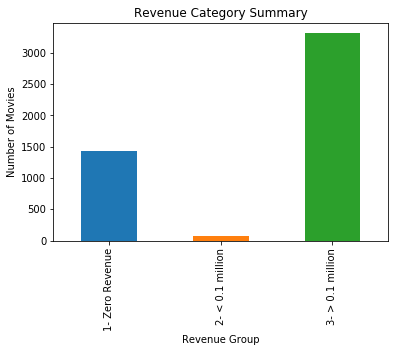

In [8]:
#df['revenue_bin']=df['revenue'].apply(lambda z: '1-Very Low' if z < 1000 else '2-Low' if z < 10000 else '3-Medium' if z < 1000000 else '4-High')
df['revenue_bin']=df['revenue'].apply(lambda z: '1- Zero Revenue' if z == 0 else '2- < 0.1 million' if z < 100000 else '3- > 0.1 million')
ax=df.groupby('revenue_bin')['id'].count().plot(kind='bar', title='Revenue Category Summary')
ax.set_xlabel('Revenue Group')
ax.set_ylabel('Number of Movies')
print(df['revenue_bin'].value_counts())

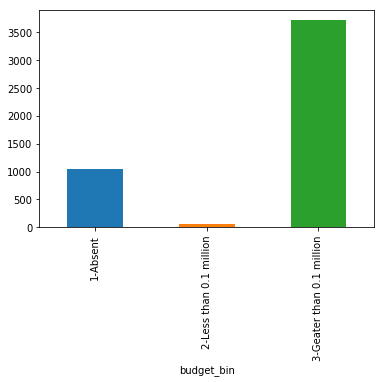

In [9]:
#df['budget_bin']=df['budget'].apply(lambda z: '1-Very Low' if z < 1000 else '2-Low' if z < 10000 else '3-Medium' if z < 1000000 else '4-High')
df['budget_bin']=df['budget'].apply(lambda z: '1-Absent' if z == 0 else '2-Less than 0.1 million' if z < 100000 else '3-Geater than 0.1 million')
df.groupby('budget_bin')['id'].count().plot(kind='bar')

#### From the above plots it is clear that revenue & budget do share the same distrubution pattern when binned into 3 categories - absent (i.e. 0), Less than 0.1million, Greater than 0.1 million. The dataset might be a but skewed as well. So lets take the log transformations as well

In [10]:
df['log_revenue']=df['revenue'].apply(lambda x : np.log1p(x))
df['log_budget']=df['budget'].apply(lambda x : np.log1p(x))

#### Below are the histogram plots of revenue column and log revennue column

Text(0, 0.5, 'Number of Records')

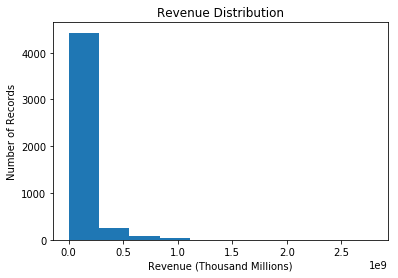

In [11]:
ax=df['revenue'].plot(kind='hist',title='Revenue Distribution')
ax.set_xlabel('Revenue (Thousand Millions)')
ax.set_ylabel('Number of Records')


Text(0, 0.5, 'Number of Records')

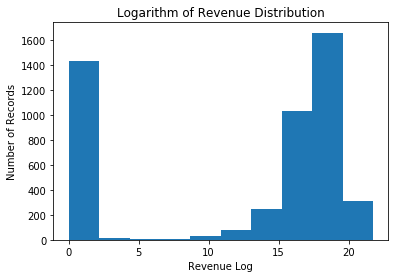

In [12]:
ax=df['log_revenue'].plot(kind='hist',title='Logarithm of Revenue Distribution')
ax.set_xlabel('Revenue Log')
ax.set_ylabel('Number of Records')


#### Distribtution for revenue and budget

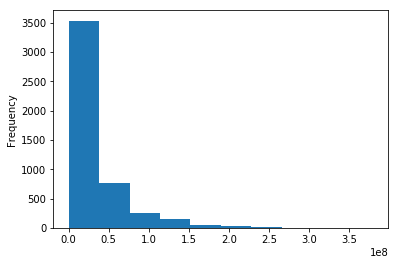

In [13]:
df['budget'].plot(kind='hist')

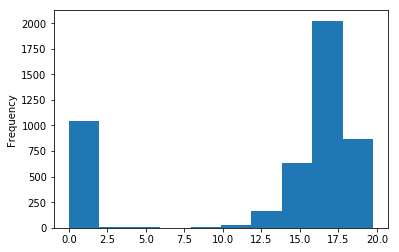

In [14]:
df['log_budget'].plot(kind='hist')

#### Revenue and Budget Relation

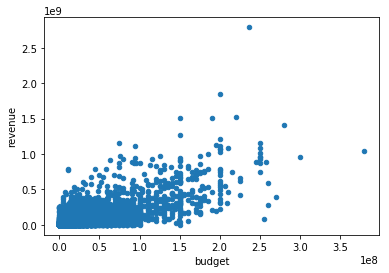

In [15]:
df.plot(x='budget', y='revenue', kind='scatter')

#### The revenue column distribution is a skewed distribution. 
From the above scatter plots it is evident that the distribution of revenue & budget follow a linear relationship. This relation will become more linear if the outliers are discarded. For now we can consider to model on log of revenue column. The Log revenue column does exhibit normal distrubution.

### Now will explore dictinary type columns - Genre, Production Companies, Production Countries,keywords, Spoken Languages 

#### The function written below is to convert the string dictionary type columns into categorical columns. The function accepts the dataframe, the column of a dataframe, unique identifier key, the predictor variable and a boolean paramter which determines whether all values of the categorical variables need to be one hot encoded or top 10/30 values need to be considered. Since the values for categorical variables - keywords, production companies exceed 1000 there is no point in including all of these as sooner number of features would outnumber the number of records. For categorical variables with values greater than 100 , will limit it to Top 30. The function returns the modified dataframe, a subset datadrame which could be used for plotting and dictionary consisting of key value pairs of that column  

In [16]:
import json
def column_calc(x,y,z):
    col=0
    for e in json.loads(x):
        if (e[z] ==y):
            col=1
    return(col)

def dict_type_cols(d1,col,kid,y,top_n=False, top_n_value=30):
    #col_dict_count_rev_df=pd.DataFrame(genre_dict_count_list)
    col_dict={}
    col_dict_count_rev_list=[]
    col_dict_count={}
    col_dict_rev={}
    col_dict_count_rev={}
    for q in range(len(d1[col])):
        qj=json.loads(d1.loc[q,col])
        for j in qj:
            #print(j)
            if(j[kid] not in col_dict):
                col_dict[j[kid]]=j['name']
                col_dict_count[j[kid]]=1
                col_dict_rev[j[kid]]=d1.loc[q,y]
            else:
                col_dict_count[j[kid]]+=1
                col_dict_rev[j[kid]]+=d1.loc[q,y]
            
            #else:
             #   col_dict[j[kid]]+=1
    for i in col_dict:
        col_dict_count_rev={}
        col_dict_count_rev['Name']=col_dict[i]
        #col_dict_count_rev['Count']=dfcheck['genre-'+genre_dict[i]].sum()
        col_dict_count_rev['Count']=col_dict_count[i]
        col_dict_count_rev['Total'+'-'+y]=col_dict_rev[i]
        col_dict_count_rev_list.append(col_dict_count_rev)
    col_dict_count_rev_df=pd.DataFrame(col_dict_count_rev_list)
    
    if(top_n):
        s = sorted(col_dict_count.items(), key=lambda x: x[1], reverse=True)
        for q in s[:top_n_value]:
            d1[col+'-'+col_dict[q[0]]]=d1[col].apply(lambda z: column_calc(z,q[0],kid))
    else:
        for q in col_dict :
            d1[col+'-'+col_dict[q]]=d1[col].apply(lambda z: column_calc(z,q,kid))

    return(d1,col_dict_count_rev_df,col_dict)



### Genres Column

In [17]:
df,genres_dict_count_rev_df,genres_dict=dict_type_cols(df,'genres','id','revenue',True,17)

In [18]:
import ast
df['Total_genres'] = df['genres'].apply(lambda z:len(ast.literal_eval(z)) if z !='[]' else 0)

### Production Countries

In [19]:
df,pcntrs_dict_count_rev_df,pcntrs_dict=dict_type_cols(df,'production_countries','iso_3166_1','revenue',True,6)

In [20]:
df['Total_production_countries'] = df['production_countries'].apply(lambda z:len(ast.literal_eval(z)) if z !='[]' else 0)

### Production Companies

In [21]:
df,pcmpns_dict_count_rev_df,pcmpns_dict=dict_type_cols(df,'production_companies','id','revenue',True,30)

In [22]:
df['Total_production_companies'] = df['production_companies'].apply(lambda z:len(ast.literal_eval(z)) if z !='[]' else 0)

### Keywords

In [23]:
df,keywords_dict_count_rev_df,keywords_dict=dict_type_cols(df,'keywords','id','revenue',True,30)

In [24]:
df['Total_keywords'] = df['keywords'].apply(lambda z:len(ast.literal_eval(z)) if z !='[]' else 0)

### Spoken Languages

In [25]:
df,spoken_langs_dict_count_rev_df,spoken_langs_dict=dict_type_cols(df,'spoken_languages','iso_639_1','revenue',True,7)

In [26]:
df['Total_spoken_languages'] = df['spoken_languages'].apply(lambda z:len(ast.literal_eval(z)) if z !='[]' else 0)

### The columns 'Title', 'tagline', 'overview' are text columns. Will create columns which will capture the length of the text. 

In [27]:
df['Title_length'] = df['title'].fillna('').apply(lambda z:len(z))
df['tagline_length'] = df['tagline'].fillna('').apply(lambda z:len(z))
df['overview_length'] = df['overview'].fillna('').apply(lambda z:len(z))
df['Title_word_length'] = df['title'].fillna('').apply(lambda z: len(str(z.split(' '))))
df['tagline_word_length'] = df['tagline'].fillna('').apply(lambda z: len(str(z.split(' '))))
df['overview_word_length'] = df['overview'].fillna('').apply(lambda z: len(str(z.split(' '))))

### For Columns - Original_Language and Homepage

#### Will convert the original_language to binary 0 (non-english), 1 (English) 

In [28]:
df['original_language_binary']=df['original_language'].apply(lambda t : 1 if t=='en' else 0)

#### Will convert the homepage_binary to binary 0 (non-english), 1 (English

In [29]:
df['homepage'].fillna(0, inplace=True)
df['homepage_binary']=df['homepage'].apply(lambda t: 0 if t==0 else 1)

### Release Year

#### Extract Release Day, Release Month,Release Day,  Day of the week from release date

In [30]:
from datetime import datetime as dt
df['release_date'].fillna('01/01/1980', inplace=True)
df['release_month']= df['release_date'].apply(lambda t: int(t.split('/')[0]) if t!='NA' else 'NA')
df['release_day']= df['release_date'].apply(lambda t: int(t.split('/')[1]) if t!='NA' else 'NA')
#dfcheck['Dump_Month']=dfcheck['release_month'].apply(lambda t : 1 if t==1 or t==2 or t==8 or t== 9 else 0)
df['release_date_format']=pd.to_datetime(df['release_date'])
df['release_weekday']=df['release_date_format'].dt.dayofweek
df.drop(['release_date_format'],axis=1, inplace=True)

In [31]:
def calc_revn_year(x):
    if(int(x.split('/')[2])>19):
        return(int('19'+x.split('/')[2]))
    else :
        return(int('20'+x.split('/')[2]))
    
calc_revn_year('01/01/80')

1980

In [32]:
df['release_year']=df['release_date'].fillna('01/01/80').apply(lambda z: calc_revn_year(z))

#### Bin runtime column as Short, Usual and Long. Short as is < 89, usual - 90 to 120, long > 120

In [33]:
df['runtime_category']=df['runtime'].apply(lambda b : 'usual' if b> 89 and b < 121 else 'long' if b > 120  else 'short')

In [34]:
df['runtime_category'].value_counts()

usual    3108
long      988
short     707
Name: runtime_category, dtype: int64

### EDA Plots - Genres, Keywords, Production Companies , Production Countries, Spoken languages, Runtime.

#### For Genres, keywords, Production Companies, Production Countries, Spoken Languages

Bar Plots - Top 10 attribute values in terms of Movie Revenue & Movie Count

Bubble Plot - Number of Movies vs Number of attribute values (exaxmple - Total Number of genres) associated with the movie

####  Trend Plots

Revenue & Budget for Last 15 years

Top 5 Genre, Keywords movie revenue trends for last 15 years



#### Genres

Text(0, 0.5, 'Number of Movies')

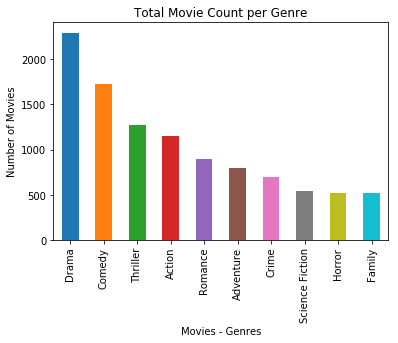

In [36]:
dfs=genres_dict_count_rev_df.sort_values(by=['Count','Total-revenue'], ascending=False)[:10]
dfs1=dfs.groupby(['Name'])['Count'].sum()
dfs1.sort_values(inplace=True, ascending=False)
ax=dfs1.plot(kind='bar', title = 'Total Movie Count per Genre')
ax.set_xlabel("Movies - Genres")
ax.set_ylabel("Number of Movies")

Text(0, 0.5, 'Total Revenue (Thousand Millions)')

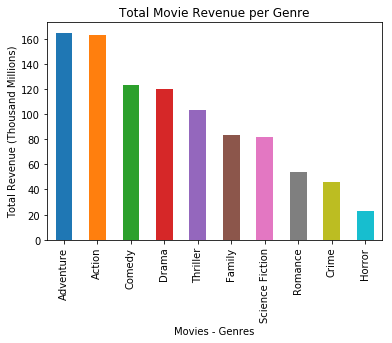

In [37]:
dfs=genres_dict_count_rev_df.sort_values(by=['Count','Total-revenue'], ascending=False)[:10]
dfs1=dfs.groupby(['Name'])['Total-revenue'].sum()
dfs1=dfs1/1000000000
dfs1.sort_values(inplace=True, ascending=False)
ax=dfs1.plot(kind='bar', title = 'Total Movie Revenue per Genre')
ax.set_xlabel("Movies - Genres")
ax.set_ylabel("Total Revenue (Thousand Millions)")

Text(0, 0.5, 'Number of Movies')

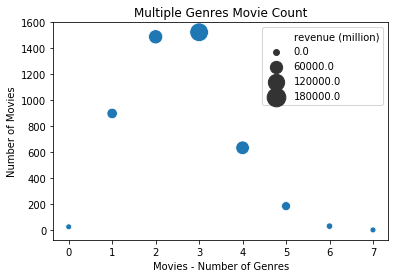

In [38]:
dfs1=pd.Series.to_frame(df.groupby(['Total_genres'])['id'].count())
dfs2=pd.Series.to_frame(df.groupby(['Total_genres'])['revenue'].sum())
dfs3=dfs1.join(dfs2)
dfs3['Num_Genres']=dfs3.index
dfs3['revenue (million)']=dfs3['revenue'].apply(lambda z: z/1000000)
#ax=dfs3.plot(kind='bar',title='Total Movie Count per Number of Genres')
ax=sns.scatterplot(y='id', x='Num_Genres', data=dfs3, size= dfs3['revenue (million)'],sizes=(35,350),legend='brief')
ax.set_title('Multiple Genres Movie Count')
ax.set_xlabel('Movies - Number of Genres')
ax.set_ylabel('Number of Movies')

#### Keywords

Text(0, 0.5, 'Number of Movies')

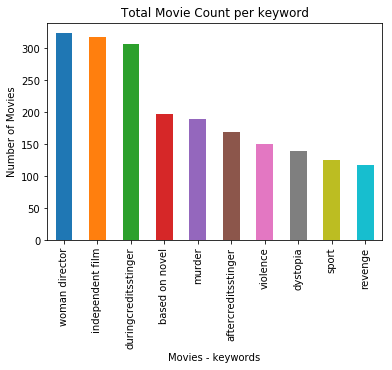

In [39]:
dfs=keywords_dict_count_rev_df.sort_values(by=['Count','Total-revenue'], ascending=False)[:10]
dfs1=dfs.groupby(['Name'])['Count'].sum()
dfs1.sort_values(inplace=True, ascending=False)
ax=dfs1.plot(kind='bar', title = 'Total Movie Count per keyword')
ax.set_xlabel("Movies - keywords")
ax.set_ylabel("Number of Movies")

Text(0, 0.5, 'Total Revenue (Thousand Millions)')

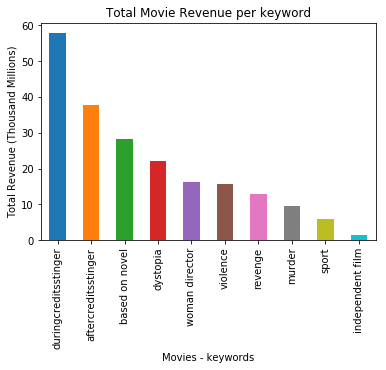

In [40]:
dfs=keywords_dict_count_rev_df.sort_values(by=['Count','Total-revenue'], ascending=False)[:10]
dfs1=dfs.groupby(['Name'])['Total-revenue'].sum()
dfs1=dfs1/1000000000
dfs1.sort_values(inplace=True, ascending=False)
ax=dfs1.plot(kind='bar', title = 'Total Movie Revenue per keyword')
ax.set_xlabel("Movies - keywords")
ax.set_ylabel("Total Revenue (Thousand Millions)")

Text(0, 0.5, 'Number of Movies')

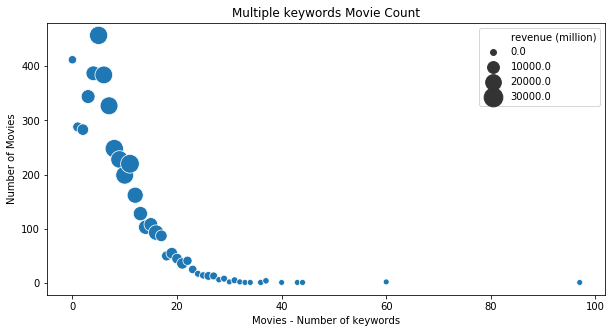

In [41]:
plt.figure(figsize=(10,5))
dfs1=pd.Series.to_frame(df.groupby(['Total_keywords'])['id'].count())
dfs2=pd.Series.to_frame(df.groupby(['Total_keywords'])['revenue'].sum())
dfs3=dfs1.join(dfs2)
dfs3['Num_keywords']=dfs3.index
dfs3['revenue (million)']=dfs3['revenue'].apply(lambda z: z/1000000)
#ax=dfs3.plot(kind='bar',title='Total Movie Count per Number of Genres')
ax=sns.scatterplot(y='id', x='Num_keywords', data=dfs3, size= dfs3['revenue (million)'],sizes=(35,350),legend='brief')
ax.set_title('Multiple keywords Movie Count')
ax.set_xlabel('Movies - Number of keywords')
ax.set_ylabel('Number of Movies')


#### Production Companies

Text(0, 0.5, 'Number of Movies')

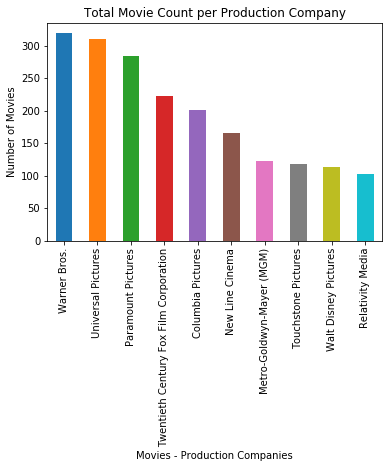

In [42]:
dfs=pcmpns_dict_count_rev_df.sort_values(by=['Count','Total-revenue'], ascending=False)[:10]
dfs1=dfs.groupby(['Name'])['Count'].sum()
dfs1.sort_values(inplace=True, ascending=False)
ax=dfs1.plot(kind='bar', title = 'Total Movie Count per Production Company')
ax.set_xlabel("Movies - Production Companies")
ax.set_ylabel("Number of Movies")

Text(0, 0.5, 'Total Revenue (Thousand Millions)')

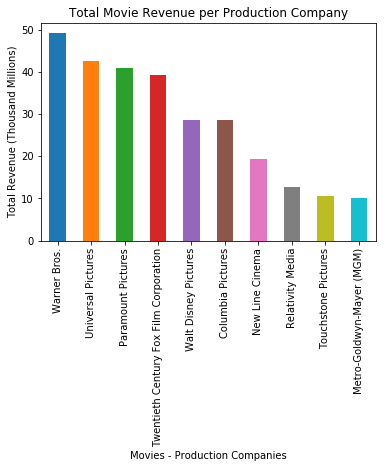

In [43]:
dfs=pcmpns_dict_count_rev_df.sort_values(by=['Count','Total-revenue'], ascending=False)[:10]
dfs1=dfs.groupby(['Name'])['Total-revenue'].sum()
dfs1=dfs1/1000000000
dfs1.sort_values(inplace=True, ascending=False)
ax=dfs1.plot(kind='bar', title = 'Total Movie Revenue per Production Company')
ax.set_xlabel("Movies - Production Companies")
ax.set_ylabel("Total Revenue (Thousand Millions)")

Text(0, 0.5, 'Number of Movies')

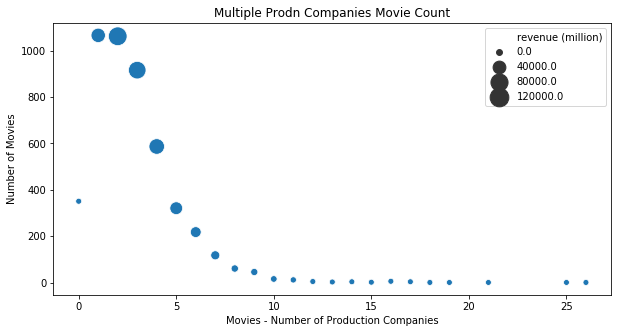

In [44]:
plt.figure(figsize=(10,5))
dfs1=pd.Series.to_frame(df.groupby(['Total_production_companies'])['id'].count())
dfs2=pd.Series.to_frame(df.groupby(['Total_production_companies'])['revenue'].sum())
dfs3=dfs1.join(dfs2)
dfs3['Num_Production_Companies']=dfs3.index
dfs3['revenue (million)']=dfs3['revenue'].apply(lambda z: z/1000000)
#ax=dfs3.plot(kind='bar',title='Total Movie Count per Number of Genres')
ax=sns.scatterplot(y='id', x='Num_Production_Companies', data=dfs3, size= dfs3['revenue (million)'],sizes=(35,350),legend='brief')
ax.set_title('Multiple Prodn Companies Movie Count')
ax.set_xlabel('Movies - Number of Production Companies')
ax.set_ylabel('Number of Movies')


#### Spoken Languages

Text(0, 0.5, 'Number of Movies')

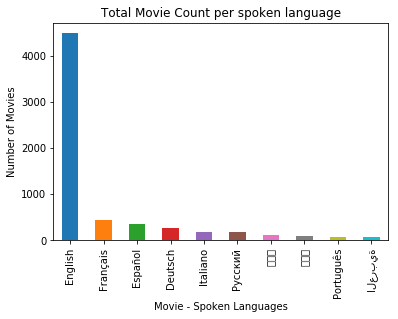

In [45]:
dfs=spoken_langs_dict_count_rev_df.sort_values(by=['Count','Total-revenue'], ascending=False)[:10]
dfs1=dfs.groupby(['Name'])['Count'].sum()
dfs1.sort_values(inplace=True, ascending=False)
ax=dfs1.plot(kind='bar', title = 'Total Movie Count per spoken language')
ax.set_xlabel("Movie - Spoken Languages")
ax.set_ylabel("Number of Movies")

Text(0, 0.5, 'Number of Movies')

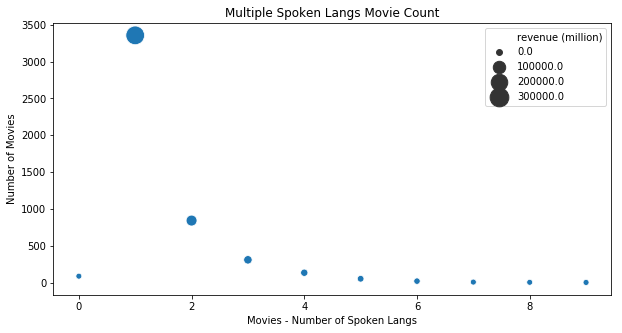

In [46]:
plt.figure(figsize=(10,5))
dfs1=pd.Series.to_frame(df.groupby(['Total_spoken_languages'])['id'].count())
dfs2=pd.Series.to_frame(df.groupby(['Total_spoken_languages'])['revenue'].sum())
dfs3=dfs1.join(dfs2)
dfs3['Num_spoken_langs']=dfs3.index
dfs3['revenue (million)']=dfs3['revenue'].apply(lambda z: z/1000000)
#ax=dfs3.plot(kind='bar',title='Total Movie Count per Number of Genres')
ax=sns.scatterplot(y='id', x='Num_spoken_langs', data=dfs3, size= dfs3['revenue (million)'],sizes=(35,350),legend='brief')
ax.set_title('Multiple Spoken Langs Movie Count')
ax.set_xlabel('Movies - Number of Spoken Langs')
ax.set_ylabel('Number of Movies')

#### Production Countries

Text(0, 0.5, 'Number of Movies')

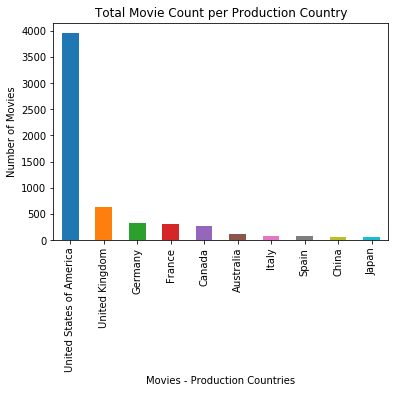

In [47]:
plt.Figure(figsize=(20,20))
dfs=pcntrs_dict_count_rev_df.sort_values(by=['Count','Total-revenue'], ascending=False)[:10]
dfs1=dfs.groupby(['Name'])['Count'].sum()
dfs1.sort_values(inplace=True, ascending=False)
ax=dfs1.plot(kind='bar', title = 'Total Movie Count per Production Country')
ax.set_xlabel("Movies - Production Countries")
ax.set_ylabel("Number of Movies")

Text(0, 0.5, 'Number of Movies')

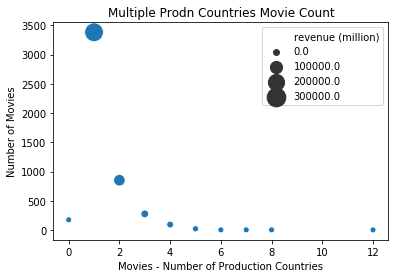

In [48]:
dfs1=pd.Series.to_frame(df.groupby(['Total_production_countries'])['id'].count())
dfs2=pd.Series.to_frame(df.groupby(['Total_production_countries'])['revenue'].sum())
dfs3=dfs1.join(dfs2)
dfs3['Num_Production_Countries']=dfs3.index
dfs3['revenue (million)']=dfs3['revenue'].apply(lambda z: z/1000000)
#ax=dfs3.plot(kind='bar',title='Total Movie Count per Number of Genres')
ax=sns.scatterplot(y='id', x='Num_Production_Countries', data=dfs3, size= dfs3['revenue (million)'],sizes=(35,350),legend='brief')
ax.set_title('Multiple Prodn Countries Movie Count')
ax.set_xlabel('Movies - Number of Production Countries')
ax.set_ylabel('Number of Movies')


#### Runtime 

#### This column has binned into three categories - Short (< 90 mins), Usual (90 mins - 120 mins) , Long (> 120 mins). 
Below are the summary of total revenue generated as per runtime category. Long Running movies have done conisderably well (revenue total - 160 million) inspite of the numbers being almost one-third of usual duration movies (revenue total -200 million).

In [49]:
df.groupby(['runtime_category'])['revenue'].sum()

runtime_category
long     163271342068
short     27384152555
usual    204442352821
Name: revenue, dtype: int64

Text(0, 0.5, 'Number of Movies')

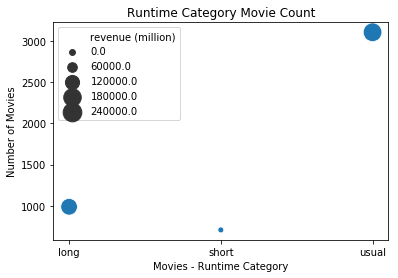

In [50]:
dfs1=pd.Series.to_frame(df.groupby(['runtime_category'])['id'].count())
dfs2=pd.Series.to_frame(df.groupby(['runtime_category'])['revenue'].sum())
dfs3=dfs1.join(dfs2)
dfs3['runtime_category']=dfs3.index
dfs3['revenue (million)']=dfs3['revenue'].apply(lambda z: z/1000000)
#ax=dfs3.plot(kind='bar',title='Total Movie Count per Number of Genres')
ax=sns.scatterplot(y='id', x='runtime_category', data=dfs3, size= dfs3['revenue (million)'],sizes=(35,350),legend='brief')
ax.set_title('Runtime Category Movie Count')
ax.set_xlabel('Movies - Runtime Category')
ax.set_ylabel('Number of Movies')

#### Revenue Budget Trend Plots, Top 5 Genre Trends, Top 5 Keywords Trends - Last 15 Years

#### Revenue Budget Plots

Text(0.5, 1.0, 'Last 15 Years Revenue Budget Trends')

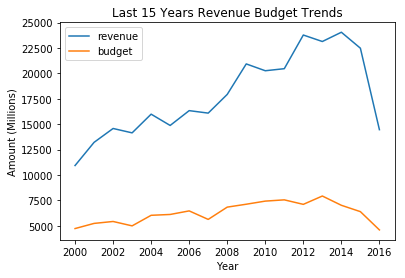

In [51]:
dfrevyear=pd.DataFrame(df[(df.release_year>1999)&(df.revenue>10000) &(df.budget>10000)].groupby(['release_year'])['revenue'].sum())
dfbudyear=pd.DataFrame(df[(df.release_year>1999)&(df.revenue>10000) & (df.budget>10000)].groupby(['release_year'])['budget'].sum())
dfrevbudyear=dfrevyear.join(dfbudyear)
dfrevbudyear['revenue']=dfrevbudyear['revenue'].apply(lambda z:z/1000000)
dfrevbudyear['budget']=dfrevbudyear['budget'].apply(lambda z:z/1000000)
dfrevbudyear['release_year']=dfrevbudyear.index
ax=dfrevbudyear.plot(x='release_year',y=['revenue','budget'], kind='line')
ax.set_ylabel("Amount (Millions)")
ax.set_xlabel("Year")
ax.set_title('Last 15 Years Revenue Budget Trends')

#### Top 5 Genre Trend Plots

In [52]:
df5genres=df[['genres-Drama','genres-Action','genres-Comedy','genres-Thriller','genres-Adventure','revenue','budget','release_year']]
df5genres.columns=['Drama','Action','Comedy','Thriller','Adventure','revenue','budget','release_year']
dfg1=pd.DataFrame(df5genres[(df5genres.release_year>1999)&(df5genres.revenue>10000) &(df5genres.budget>10000) & (df5genres.Drama==1)].groupby(['release_year'])['revenue'].sum())
dfg1.columns=['Revenue-Drama']
dfg2=pd.DataFrame(df5genres[(df5genres.release_year>1999)&(df5genres.revenue>10000) &(df5genres.budget>10000)& (df5genres.Comedy==1)].groupby(['release_year'])['revenue'].sum())
dfg2.columns=['Revenue-Comedy']
dfg3=pd.DataFrame(df5genres[(df5genres.release_year>1999)&(df5genres.revenue>10000) &(df5genres.budget>10000)& (df5genres.Thriller==1)].groupby(['release_year'])['revenue'].sum())
dfg3.columns=['Revenue-Thriller']
dfg4=pd.DataFrame(df5genres[(df5genres.release_year>1999)&(df5genres.revenue>10000) &(df5genres.budget>10000) & (df5genres.Action==1)].groupby(['release_year'])['revenue'].sum())
dfg4.columns=['Revenue-Action']
dfg5=pd.DataFrame(df[(df5genres.release_year>1999)&(df5genres.revenue>10000) &(df5genres.budget>10000)&(df5genres.Adventure==1)].groupby(['release_year']) ['revenue'].sum())
dfg5.columns=['Revenue-Adventure']

In [53]:
dfg=dfg1.join(dfg2)
for i in (dfg3, dfg4, dfg5):
    dfg=dfg.join(i)
for i in dfg.columns:
    dfg[i]=dfg[i].apply(lambda x:x/1000000)
dfg['Year']=dfg.index


Text(0.5, 0, 'Year')

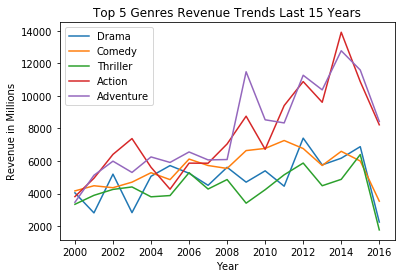

In [54]:
dfg5=dfg[['Revenue-Drama','Revenue-Comedy','Revenue-Thriller','Revenue-Action','Revenue-Adventure','Year']]
dfg5.columns=['Drama','Comedy','Thriller','Action','Adventure','Year']
#ax=dfg.plot(x='Year',y=['genres-Drama','genres-Comedy','genres-Thriller','genres-Action','genres-Romance'], kind='line',legend=True)
ax=dfg5.plot(x='Year',y=['Drama','Comedy','Thriller','Action','Adventure'], kind='line',legend=True, title='Top 5 Genres Revenue Trends Last 15 Years')
ax.set_ylabel('Revenue in Millions')
ax.set_xlabel('Year')
#ax.set_figure(10)
#,'genres-Adventure','genres-Crime','genres-Horror','genres-Family'], kind='line
#ax.figure=(10,10)

#### Top 5 Keywords Trend Plots

In [55]:
df5keywords=df[['keywords-aftercreditsstinger','keywords-duringcreditsstinger','keywords-based on novel','keywords-dystopia','keywords-woman director','revenue','budget','release_year']]
df5keywords.columns=['aftercreditssinger','duringcreditssinger','basedonnovel','dystopia','womandirector','revenue','budget','release_year']
dfk0=pd.DataFrame(df5keywords[(df5keywords.release_year>1999)&(df5keywords.revenue>10000) &(df5keywords.budget>10000) & (df5keywords.aftercreditssinger==1)].groupby(['release_year'])['revenue'].sum())
dfk0.columns=['Revenue-aftercreditsstinger']
dfk1=pd.DataFrame(df5keywords[(df5keywords.release_year>1999)&(df5keywords.revenue>10000) &(df5keywords.budget>10000)& (df5keywords.duringcreditssinger==1)].groupby(['release_year'])['revenue'].sum())
dfk1.columns=['Revenue-duringcreditsstinger']
dfk2=pd.DataFrame(df5keywords[(df5keywords.release_year>1999)&(df5keywords.revenue>10000) &(df5keywords.budget>10000)& (df5keywords.basedonnovel==1)].groupby(['release_year'])['revenue'].sum())
dfk2.columns=['Revenue-basedonnovel']
dfk3=pd.DataFrame(df5keywords[(df5keywords.release_year>1999)&(df5keywords.revenue>10000) &(df5keywords.budget>10000) & (df5keywords.dystopia==1)].groupby(['release_year'])['revenue'].sum())
dfk3.columns=['Revenue-dystopia']
dfk4=pd.DataFrame(df[(df5keywords.release_year>1999)&(df5keywords.revenue>10000) &(df5keywords.budget>10000)&(df5keywords.womandirector==1)].groupby(['release_year']) ['revenue'].sum())
dfk4.columns=['Revenue-womandirector']

In [56]:
dfk=dfk0.join(dfk1)
for q in (dfk2,dfk3,dfk4):
    dfk=dfk.join(q)
for i in dfk.columns:
    dfk[i]=dfk[i].apply(lambda x:x/1000000)
dfk['Year']=dfk.index



Text(0.5, 0, 'Year')

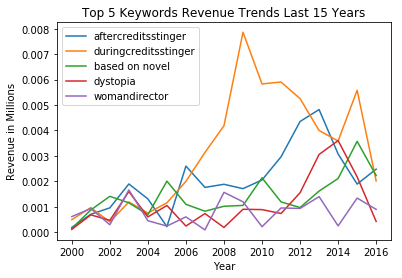

In [57]:
dfk['Year']=dfk.index
dfk['Revenue-aftercreditsstinger']=dfk['Revenue-aftercreditsstinger'].apply(lambda x:x/1000000)
dfk['Revenue-duringcreditsstinger']=dfk['Revenue-duringcreditsstinger'].apply(lambda x:x/1000000)
dfk['Revenue-basedonnovel']=dfk['Revenue-basedonnovel'].apply(lambda x:x/1000000)
dfk['Revenue-dystopia']=dfk['Revenue-dystopia'].apply(lambda x:x/1000000)
dfk['Revenue-womandirector']=dfk['Revenue-womandirector'].apply(lambda x:x/1000000)
dfk5=dfk[['Revenue-aftercreditsstinger','Revenue-duringcreditsstinger','Revenue-basedonnovel','Revenue-dystopia','Revenue-womandirector','Year']]
dfk5.columns=['aftercreditsstinger','duringcreditsstinger','based on novel','dystopia','womandirector','Year']
#ax=dfg.plot(x='Year',y=['genres-Drama','genres-Comedy','genres-Thriller','genres-Action','genres-Romance'], kind='line',legend=True)
ax=dfk5.plot(x='Year',y=['aftercreditsstinger','duringcreditsstinger','based on novel','dystopia','womandirector'], kind='line',legend=True, title='Top 5 Keywords Revenue Trends Last 15 Years')
ax.set_ylabel('Revenue in Millions')
ax.set_xlabel('Year')

### Feature Engineering

### Overview Column

#### Generally a movie needs to have a good storyline to hit the bull's eye. In the provided dataset, we have an overview column that summarizes the whole movie. It would be safe to assume that good movie means good overview/plot. The idea would be generate vector representation of the overview using TF vectorizer. Then from existing dataset, referring the records with valid budget & revenue values, segregate these into good plot (1), bad plot (0). A classification model to be trained on this dataset which would predict the class probability on a given vector representation of a movie overview. This probability score to be then used as a Plot score input to the regression model. 

In [58]:
dfplot=df[(df.revenue>10000) & (df.budget>10000)]
dfplot['Profit_Percent']=100*(dfplot['revenue']-dfplot['budget'])/(dfplot['budget'])

c:\users\ravi_\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Records with negative profit percentage values will be categorized as bad plots i.e. Plot_Quality = 0

In [59]:
dfplot['Plot_Quality']=dfplot['Profit_Percent'].apply(lambda x1: 0 if x1< 0 else 1)
dfplot['Plot_Quality'].value_counts()

c:\users\ravi_\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


1    2428
0     775
Name: Plot_Quality, dtype: int64

c:\users\ravi_\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


18300


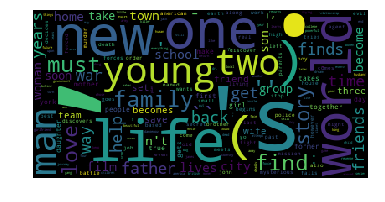

In [60]:
dfplot['overview']= dfplot['overview'].str.lower()
reviews = dfplot.overview.str.cat(sep=' ')
tokens = word_tokenize(reviews)
vocabulary = set(tokens)
print(len(vocabulary))
stop_words = set(stopwords.words('english'))
tokens_clean = [w for w in tokens if not w in stop_words]
frequency_dist = nltk.FreqDist(tokens_clean)
from wordcloud import WordCloud
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequency_dist)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Using Cross Validation techinque to evaluate the model

In [61]:
vectorizer = TfidfVectorizer()
X_vectors=vectorizer.fit_transform(dfplot['overview'].values)
y_vectors=dfplot['Plot_Quality'].values

In [62]:
X_vectors.shape

(3203, 16993)

#### Now evaluating the algorithm for calculating Plot Score by performing cross validation. Decision Trees, Random Forest, Adaboost Classifier, LGBM, XGBOOST algorithms considered.ROC_AUC_SCORE selected as the metrics,mumber of folds=4

In [63]:
from sklearn.metrics import roc_auc_score, roc_curve


In [64]:
n_fold = 4
ax_list=[]
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
ml1=LogisticRegression()
#ml1=LogisticRegression(solver='lbfgs',class_weight='balanced', max_iter=500, C=0.001)
ml2=DecisionTreeClassifier()
ml3=RandomForestClassifier(n_estimators=100)
ml4=AdaBoostClassifier()
ml5=LGBMClassifier()
ml6=SVC(probability=True,gamma='auto')
ml7=xgb.XGBClassifier()
ml1_error=[]
ml2_error=[]
ml3_error=[]
ml4_error=[]
ml5_error=[]
ml6_error=[]
ml7_error=[]
i=0
for fold_n, (train_index, valid_index) in enumerate(folds.split(X_vectors)):#[:3000])):
    #print('\n')
    X1_train, X1_valid = X_vectors[train_index], X_vectors[valid_index]
    y1_train, y1_valid = y_vectors[train_index],y_vectors[valid_index]
    i=0
    for m in [ml1,ml2,ml3,ml4,ml5,ml6,ml7]:
        m.fit(X1_train, y1_train)
        y_pred_valid = m.predict_proba(X1_valid)
        y_pred_valid_prob=[]
        for q in y_pred_valid:
            y_pred_valid_prob.append(q[1])
        #print(mean_squared_error(y1_valid,y_pred_valid))
        if(i==0):
            #print(roc_auc_score(y1_valid,y_pred_valid_prob))
            ml1_error.append(roc_auc_score(y1_valid,y_pred_valid_prob))
        elif(i==1):
            ml2_error.append(roc_auc_score(y1_valid,y_pred_valid_prob))
        elif(i==2):
            ml3_error.append(roc_auc_score(y1_valid,y_pred_valid_prob))
        elif(i==3):
            ml4_error.append(roc_auc_score(y1_valid,y_pred_valid_prob))
        elif(i==4):
            ml5_error.append(roc_auc_score(y1_valid,y_pred_valid_prob))
        elif(i==5):
            ml6_error.append(roc_auc_score(y1_valid,y_pred_valid_prob))
        i=i+1
        #print('Model Trained for Fold')

print('\n')
#print(ml1_error)
#print(ml2_error)
print(np.mean(ml1_error))
print(np.mean(ml2_error))
print(np.mean(ml3_error))
print(np.mean(ml4_error))
print(np.mean(ml5_error))
print(np.mean(ml6_error))



c:\users\ravi_\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\ravi_\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\ravi_\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\ravi_\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)




0.5736491006416634
0.5086317956702331
0.5508444178054674
0.54542031076
0.5310203160250363
0.5643616820733051



#### Logistic Regression Algorithm performs the best so far, roc_auc_score of 0.5736. Will go ahead with Logistic Regression

In [65]:
m2=LogisticRegression()
m2.fit(X_vectors,y_vectors)

c:\users\ravi_\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#### WIth the Trained LR Model, caluclating the PLot Score for the entire dataset

In [66]:
df['overview']= df['overview'].str.lower()
df['overview'].fillna('Not Available', inplace=True)
overview_vectors = vectorizer.transform(df['overview'])
overview_prob=m2.predict_proba(overview_vectors)
overview_score=[]
for i in overview_prob:
    overview_score.append(i[1])
#overview_score_df=pd.DataFrame(data=overview_score, index=dfoverview.index, columns=['Plot_Score'])
df['Plot_Score']=overview_score

In [67]:
df['Plot_Score'].describe()

count    4803.000000
mean        0.757750
std         0.075321
min         0.457484
25%         0.716479
50%         0.774418
75%         0.812527
max         0.916349
Name: Plot_Score, dtype: float64

#### Checking Distribution of the Plot Score

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B1BC454518>]],
      dtype=object)

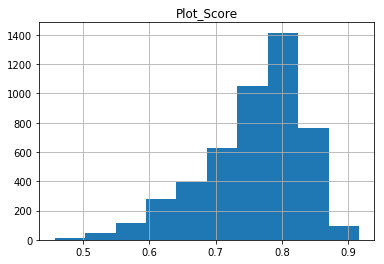

In [68]:
df.hist('Plot_Score')

             Plot_Score  log_revenue
Plot_Score     1.000000     0.476802
log_revenue    0.476802     1.000000


Text(0, 0.5, 'Revenue (logarithm scale)')

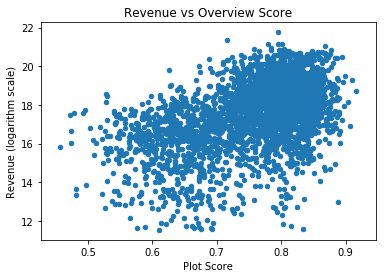

In [69]:
print(df[(df.revenue>100000)][['Plot_Score','log_revenue']].corr()) ## Cor-relation with the records conisdered for training , revenue > 0.1 million
ax=df[(df.revenue>100000)].plot(x='Plot_Score', y='log_revenue', kind='scatter',title='Revenue vs Overview Score')
#ax.title='Revenue vs Overview Score'
ax.set_xlabel('Plot Score')
ax.set_ylabel('Revenue (logarithm scale)')

### Release Date
There is a concept called Dump Months - https://en.wikipedia.org/wiki/Dump_months . Normally low budget movies or movies not expected to do well are released in this period. The Dump months consititute of January, Februry, August & September. We can add one binary column Dump Month based on release month. 

In [70]:
df['Dump_Month']=df['release_month'].apply(lambda t : 1 if t==1 or t==2 or t==8 or t== 9 else 0)

### Train the Model


#### Here please note the budget column and the revenue column do share a very strong co-relation and it becomes an obvious choice for one of the features during predictive modelling for revenue. But the problem statement is that at the time of prediction this feature or rather the budget value is often an unknown factor. The approach to be adopted by the business would be to get the revenue prediction from the model without the budget input and then accordingly decide on budget allocation i.e. green lighting the project. So here for the model training, the budget column will not be taken into consideration as a feature


In [71]:
len(df.columns)

130

#### As shown in the graph above for revenue and budget, there are approax 1400 records with 0 value in revenue column. These records have to be filtered out as there is no case of 0 revenue. Lets check if the 0 values get filtered out by applying the outlier validation. 

In [72]:
df3=df[(np.abs(stats.zscore(df['revenue'])) < 3)]
df3['revenue'].describe()

count    4.685000e+03
mean     6.305920e+07
std      1.004487e+08
min      0.000000e+00
25%      0.000000e+00
50%      1.743216e+07
75%      8.414683e+07
max      5.637493e+08
Name: revenue, dtype: float64

In [73]:
df3['revenue_bin'].value_counts()

3- > 0.1 million    3193
1- Zero Revenue     1427
2- < 0.1 million      65
Name: revenue_bin, dtype: int64

#### The 0 values are still present. Applying the outlier criteria is not helping, will have to proceed by dropping these rows

In [74]:
dfmodel=pd.get_dummies(df, columns=['runtime_category'], drop_first=True)
drop_cols=['title', 'tagline', 'genres','id', 'homepage','keywords', 'original_language', 'overview','release_date','production_companies', 'production_countries','spoken_languages','status','budget','revenue_bin', 'budget_bin','log_budget']#,'release_month','release_day','release_weekday']
dfmodel.drop(drop_cols,axis=1,inplace=True)


In [75]:
dfmodel.columns

Index(['revenue', 'runtime', 'log_revenue', 'genres-Drama', 'genres-Comedy',
       'genres-Thriller', 'genres-Action', 'genres-Romance',
       'genres-Adventure', 'genres-Crime',
       ...
       'original_language_binary', 'homepage_binary', 'release_month',
       'release_day', 'release_weekday', 'release_year', 'Plot_Score',
       'Dump_Month', 'runtime_category_short', 'runtime_category_usual'],
      dtype='object', length=114)

#### For training the model, will select the rows with revenue > 0.1 million. The records with 0 values are anyways to be discarded and the number of records with revenue value less than 0.1 million is around 60. So we can proceed by selecting only those rows with revenue value greater than 0.1 million.  

#### Test Model Data Frame & Train Model Data Frame

In [76]:
dfcheck=df[df['revenue']<100000]
dfmodel=dfmodel[dfmodel['revenue']>100000]

In [77]:
dfmodel.dropna(inplace=True)
len(dfmodel)

3311

In [78]:
X=dfmodel.drop(['revenue','log_revenue'],axis=1)
y=dfmodel['log_revenue']
print(len(X.columns))

112


In [79]:
X1=X.reset_index()
y1=y.reset_index()
y_newvalues=y1['log_revenue'].values
X_new=X1.drop(['index'],axis=1)
X_newvalues=X_new.values

#### Now evaluating the algorithm for training the model by performing cross validation. Linear Regression, Decision Trees, Random Forest, Adaboost, LGBM, XGBOOST algorithms considered. RMSE selected as the metric.Number of folds for cross validation =4 

In [80]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
ml1=LGBMRegressor()
ml2=xgb.XGBRegressor()
ml3=DecisionTreeRegressor()
ml4=RandomForestRegressor()
ml5=AdaBoostRegressor()
#m6=LGBMClassifier()
ml6=LinearRegression()
#m8=xgb.XGBClassifier()
n_fold = 4
ax_list=[]
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
ml1_error=[]
ml2_error=[]
ml3_error=[]
ml4_error=[]
ml5_error=[]
ml6_error=[]
i=0
for fold_n, (train_index, valid_index) in enumerate(folds.split(X_newvalues)):#[:3000])):
    #print('\n')
    X1_train, X1_valid = X_newvalues[train_index], X_newvalues[valid_index]
    y1_train, y1_valid = y_newvalues[train_index],y_newvalues[valid_index]
    i=0
    for m in [ml1,ml2, ml3,ml4,ml5,ml6]:
        m.fit(X1_train, y1_train)
        y_pred_valid = m.predict(X1_valid)
        #print(mean_squared_error(y1_valid,y_pred_valid))
        if(i==0):
            #print(mean_squared_error(y1_valid,y_pred_valid))
            ml1_error.append(mean_squared_error(y1_valid,y_pred_valid))
        elif(i==1):
            ml2_error.append(mean_squared_error(y1_valid,y_pred_valid))
        elif(i==2):
            ml3_error.append(mean_squared_error(y1_valid,y_pred_valid))
        elif(i==3):
            ml4_error.append(mean_squared_error(y1_valid,y_pred_valid))
        elif(i==4):
            ml5_error.append(mean_squared_error(y1_valid,y_pred_valid))
        elif(i==5):
            ml6_error.append(mean_squared_error(y1_valid,y_pred_valid))
        i=i+1
        #print('Model Trained for Fold')

print('\n')
#print(ml1_error)
#print(ml2_error)
print(np.sqrt(np.mean(ml1_error)))
print(np.sqrt(np.mean(ml2_error)))
print(np.sqrt(np.mean(ml3_error)))
print(np.sqrt(np.mean(ml4_error)))
print(np.sqrt(np.mean(ml5_error)))
print(np.sqrt(np.mean(ml6_error)))


        
    

c:\users\ravi_\appdata\local\programs\python\python35\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)




1.1255929408292722
1.109579974609624
1.6873797171629474
1.2248399337683717
1.3900254276912498
1.1505617142096893


### Light GBM Algorithm selected. Parameter tunning further done to  reduce the error to 1.0971
A note over here, Xgboost did perform slightly better with cross validation rmse error = 1.109.Here above shuffle parameter is true. However if we perform cross validation with shuffle equal to False then Xgboost error is higher as compared to Lightgbm. The resultant mean rmse error is slightly low for LightGBM hence lightgbm selected.

In the below cell,parameters were tuned for Lightgbm. Num_leaves =30, min_data_in_leaf=25, max_depth=5,learning_rate=0.01,bagging_frequency=1

Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[1106]	valid_0's rmse: 0.815697	valid_1's rmse: 1.07954


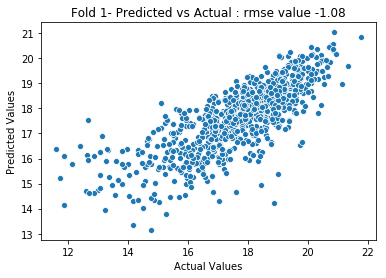

Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[1166]	valid_0's rmse: 0.809325	valid_1's rmse: 1.08138


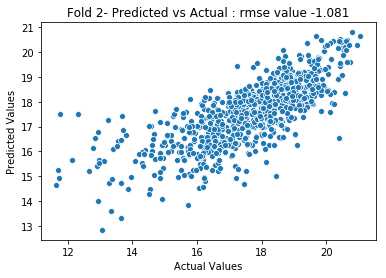

Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[1356]	valid_0's rmse: 0.771973	valid_1's rmse: 1.13503


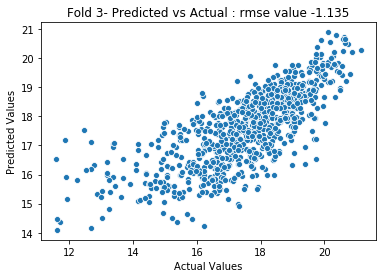

Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[1133]	valid_0's rmse: 0.816612	valid_1's rmse: 1.09162


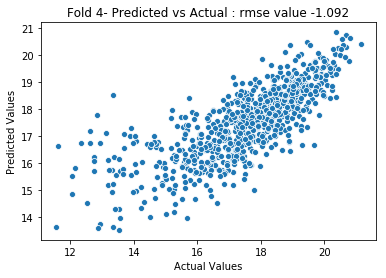

1.0971247324621316


c:\users\ravi_\appdata\local\programs\python\python35\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


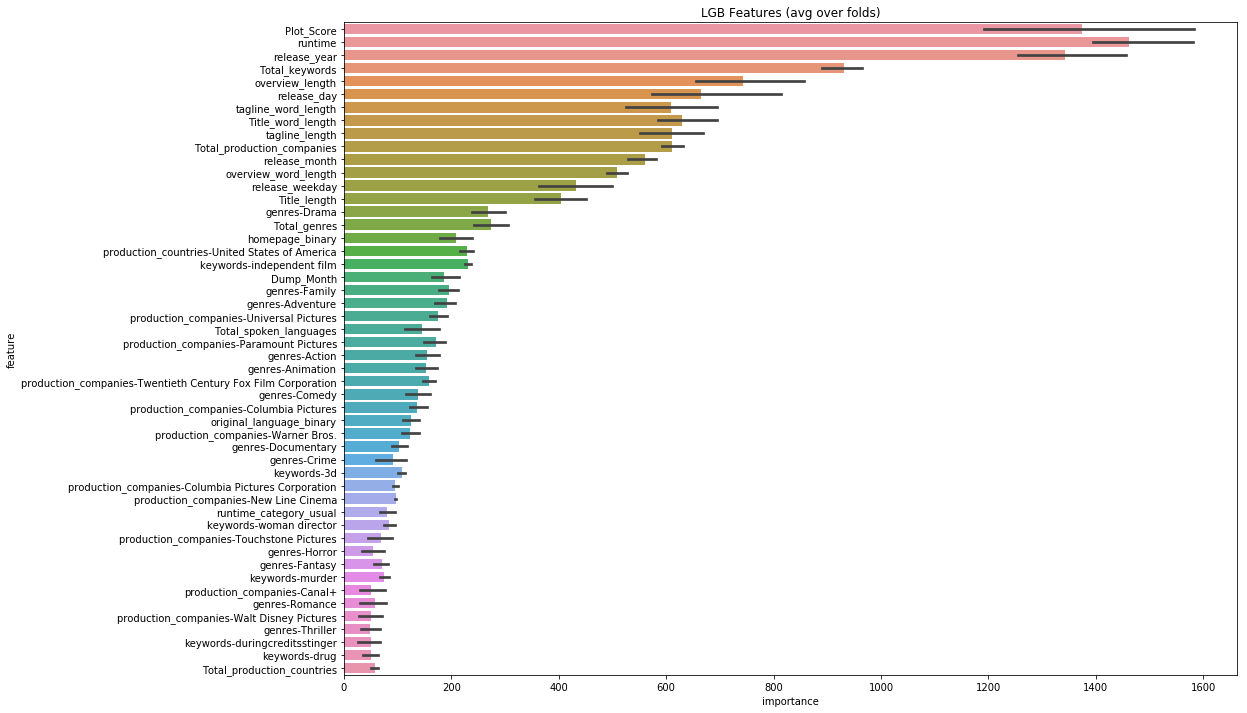

In [81]:
n_fold = 4
ax_list=[]
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
params = {'num_leaves': 30,#30,#10,#5
          'random_state':None,
         'min_data_in_leaf': 25,#25,20,#5
         'objective': 'regression',
         'max_depth':5,#5,#4
         'learning_rate': 0.01,#0.01
         "boosting": "gbdt",#"gbdt",
        "feature_fraction": 0.9,#0.9
        "bagging_freq": 1,#1
         "bagging_fraction": .9,#.9
        "bagging_seed": 11, #11,
        "metric": 'rmse',
         "lambda_l1": 0.2}#, #0.2
         #"lambda_l1":0.01,#added
         #"max_bin":30}# added
        # "verbosity": -1}
#model1 = LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
model1 = LGBMRegressor(n_estimators = 5000, nthread = 4, n_jobs = -1)
validation_rmse=[]
test_rmse=[]
feature_importance = pd.DataFrame()

for fold_n, (train_index, valid_index) in enumerate(folds.split(X_newvalues)):#[:3000])):
    X1_train, X1_valid = X_newvalues[train_index], X_newvalues[valid_index]
    y1_train, y1_valid = y_newvalues[train_index],y_newvalues[valid_index]
    model1 = LGBMRegressor(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)
    #model1 = LGBMRegressor()
    #model1 = LGBMRegressor(n_estimators = 20000, nthread = 4, n_jobs = -1)
    model1.fit(X1_train, y1_train, 
        eval_set=[(X1_train, y1_train), (X1_valid, y1_valid)], eval_metric='rmse',#'rmse',
        verbose=-1, early_stopping_rounds=300)
    y_pred_valid = model1.predict(X1_valid)
    ax = sns.scatterplot(x=y1_valid, y=y_pred_valid)
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')
    ax.set_title('Fold ' + str(fold_n+1) +  '- Predicted vs Actual : rmse value -'+ str(round(np.sqrt(mean_squared_error(y1_valid,y_pred_valid)),3)))
    plt.show()

    #y_pred = model1.predict(X_newvalues[3000:], num_iteration=model1.best_iteration_)
    validation_rmse.append(mean_squared_error(y1_valid,y_pred_valid))
    #validation_rmse.append(r2_score(y1_valid,y_pred_valid))
    #test_rmse.append(mean_squared_error(y_new[3000:],y_pred))
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = X_new.columns
    fold_importance["importance"] = model1.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)


print(np.sqrt(np.mean(validation_rmse)))
#print(np.mean(validation_rmse))
#print(np.sqrt(np.mean(np.abs(test_rmse))))    
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');


#### Train the model on entire dataset

In [82]:
model1 = LGBMRegressor(**params, n_estimators =5000, nthread = 4, n_jobs = -1)

model1.fit(X_newvalues,y_newvalues)

LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, bagging_seed=11,
       boosting='gbdt', boosting_type='gbdt', class_weight=None,
       colsample_bytree=1.0, feature_fraction=0.9, importance_type='split',
       lambda_l1=0.2, learning_rate=0.01, max_depth=5, metric='rmse',
       min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=25,
       min_split_gain=0.0, n_estimators=5000, n_jobs=-1, nthread=4,
       num_leaves=30, objective='regression', random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

### Outlier Dataset Prediction

In [83]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#### This set is the data which was discarded during the training. As the dataset consisted of revenue values as 0 or values if present was less than 0.1 million

In [84]:
dfcheck=df[df['revenue']<100000]
drop_cols_check=['title', 'tagline', 'genres', 'homepage', 'id','keywords', 'original_language', 'overview','release_date','production_companies', 'production_countries','spoken_languages','status','budget','revenue_bin', 'budget_bin','log_budget','revenue','log_revenue']
X_check=dfcheck.drop(drop_cols_check,axis=1)
#y_pred_check=model1.predict(X_check)
X_check['runtime_category_short']=X_check['runtime_category'].apply(lambda x : 1 if x=='short' else 0)
X_check['runtime_category_usual']=X_check['runtime_category'].apply(lambda x : 1 if x=='usual' else 0)
X_check.drop(['runtime_category'], axis=1,inplace=True)
X_check.columns

Index(['runtime', 'genres-Drama', 'genres-Comedy', 'genres-Thriller',
       'genres-Action', 'genres-Romance', 'genres-Adventure', 'genres-Crime',
       'genres-Science Fiction', 'genres-Horror',
       ...
       'original_language_binary', 'homepage_binary', 'release_month',
       'release_day', 'release_weekday', 'release_year', 'Plot_Score',
       'Dump_Month', 'runtime_category_short', 'runtime_category_usual'],
      dtype='object', length=112)

In [85]:
y_pred_check=model1.predict(X_check)
dfcheck['Predicted_Revenue_log']=y_pred_check
dfcheck['Predicted_Revenue']= dfcheck['Predicted_Revenue_log'].apply(lambda z: np.expm1(z))
dfcheck['Predicted_Revenue_str']=dfcheck['Predicted_Revenue'].apply(lambda x : str(round(x/1000000,2))+' million USD')

c:\users\ravi_\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\ravi_\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\ravi_\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [86]:
# Discarded set having revenue =0
dfcheck[['title','id','release_date','budget','Predicted_Revenue_str','Predicted_Revenue','Predicted_Revenue_log']][dfcheck['budget']>0].head(10)

,title,id,release_date,budget,Predicted_Revenue_str,Predicted_Revenue,Predicted_Revenue_log
83,The Lovers,79698,2/13/15,27000000,9.3 million USD,9302647.837,16.046
135,The Wolfman,7978,2/11/10,150000000,68.94 million USD,68941446.881,18.049
309,Son of the Mask,10214,2/18/05,84000000,60.85 million USD,60845770.270,17.924
376,Volcano,10357,4/25/97,90000000,12.89 million USD,12892192.082,16.372
433,RED 2,146216,7/18/13,84000000,161.68 million USD,161680274.881,18.901
467,Mighty Joe Young,9822,12/25/98,90000000,28.57 million USD,28565715.955,17.168
471,Little Nicky,9678,11/10/00,85000000,94.42 million USD,94415307.123,18.363
492,Top Cat Begins,293644,10/30/15,8000000,13.65 million USD,13651998.780,16.429
518,Inspector Gadget,332,7/23/99,75000000,45.24 million USD,45241985.423,17.628
536,Anna and the King,1439,12/16/99,75000000,130.66 million USD,130661382.807,18.688


In [87]:
# Discarded Set having both revenue and budget =0 
dfcheck[['title','id','release_date','budget','Predicted_Revenue_str','Predicted_Revenue','Predicted_Revenue_log']][dfcheck['budget']==0].head(10)

,title,id,release_date,budget,Predicted_Revenue_str,Predicted_Revenue,Predicted_Revenue_log
265,The Cat in the Hat,10588,11/21/03,0,123.07 million USD,123067692.633,18.628
406,Arthur Christmas,51052,2/22/11,0,149.71 million USD,149708044.919,18.824
453,The Pink Panther,12096,1/18/06,0,93.61 million USD,93607009.183,18.355
463,Déjà Vu,161795,4/22/98,0,59.08 million USD,59080037.245,17.894
474,Evolution,330770,9/14/15,0,8.92 million USD,8919580.923,16.004
584,Wolf,10395,6/17/94,0,60.78 million USD,60784570.992,17.923
601,Rollerball,11535,2/8/02,0,45.49 million USD,45486361.026,17.633
721,Kangaroo Jack,10628,1/17/03,0,35.43 million USD,35429810.343,17.383
735,The Tuxedo,10771,9/27/02,0,70.66 million USD,70663861.954,18.073
745,Miss Congeniality 2: Armed and Fabulous,10040,3/11/05,0,72.97 million USD,72968398.496,18.106


#### Top 30 Predictions

#### Referring the above record set for predictions, cross verified from the internet (Wikipedia /IMDB) for actual revenue values for the records. Below are the Top 30 predictions of the model. The difference between the actual values and predicted values are in the range of 5 million dollars. The mean revenue of the records considered for training is 119 million dollars, so 5% deviation has been considered for top predictions.

In [90]:
dfcheck[dfcheck['title']=='Wolves']

,title,tagline,revenue,budget,genres,homepage,id,keywords,original_language,overview,...,release_month,release_day,release_weekday,release_year,runtime_category,Plot_Score,Dump_Month,Predicted_Revenue_log,Predicted_Revenue,Predicted_Revenue_str
2394,Wolves,Unleash the beast,0,18000000,"[{""id"": 27, ""name"": ""Horror""}, {""id"": 28, ""nam...",0,290555,"[{""id"": 2393, ""name"": ""adoption""}, {""id"": 1256...",en,the coming-of-age story of cayden richards. fo...,...,8,28,3,2014,usual,0.746,1,16.388,13103525.212,13.1 million USD


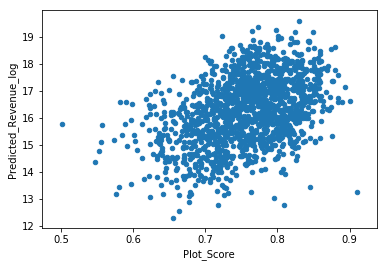

In [88]:

dfcheck.plot(x='Plot_Score',y='Predicted_Revenue_log', kind='scatter')

In [89]:
dfpred= pd.read_csv('Top_30_Predictions.csv',sep='|')
dfpred.head(30)

,Movie Title,Movie Id,Release Date,Budget,Actual Revenue (Rounded),Predicted Revenue (Rounded),Difference (in Millions),Predicted Revenue (Exact)
0,The Glimmer Man,9625,10/4/96,45 million USD,20.35 million USD,20.19 million USD,0.160,20190210.388
1,People I Know,11458,11/21/02,20 million USD,5.484 million USD,5.26 million USD,0.224,5261526.037
2,One Missed Call,6933,1/4/08,20 million USD,45.8 million USD,45.31 million USD,0.490,45312558.375
3,Money Talks,9416,8/22/97,0,48.4 million USD,49.25 million USD,0.850,49251614.841
4,Son of the Mask,10214,2/18/05,84 million USD,59.9 million USD,60.85 million USD,0.950,60845770.270
5,Wolves,290555,8/28/14,18 million USD,12.1 million USD,13.1 million USD,1.000,13103525.212
6,For Love of the Game,10390,9/17/99,50 million USD,46.1 million USD,44.91 million USD,1.190,44913212.261
7,Cry Freedom,12506,11/5/87,0,5.9 million USD,4.53 million USD,1.370,4530780.917
8,Brazil,68,2/20/85,15 million USD,9.9 million USD,8.38 million USD,1.520,8377886.957
9,I Come with the Rain,31166,5/14/09,18 million USD,4.748 million USD,6.31 million USD,1.560,6309853.032


In [89]:
dfpred['Difference (in Millions)'].mean() # Mean deviation in Millions for Top30 predictions

2.63085

In [91]:
#### Exporting objects for reference for reproducibility
joblib.dump(model1,'LGBM_Movie_Predictions_Model.pkl')
joblib.dump(vectorizer,'Overview_Vectors_Transform_Model.pkl')
joblib.dump(m2,'Plot_Score_Calc_Model.pkl')

['Plot_Score_Calc_Model.pkl']